In [2]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 22.5MB/s 


In [3]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
import keras
import sys
import h5py
import numpy as np
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [5]:
!mkdir -p drive
!google-drive-ocamlfuse drive 
import os
os.chdir("/content/drive/MLsecurity_project") 

In [6]:
pip install -q tensorflow-model-optimization

# BadNet1: Sunglasses_BD_NET

In [7]:
SunModel = keras.models.load_model("/content/drive/MLsecurity_project/models/sunglasses_bd_net.h5")
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data']).astype(np.float32)
    y_data = np.array(data['label']).astype(np.float32)
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data
def data_preprocess(x_data):
    return x_data/255
clean_data_filename = "/content/drive/MLsecurity_project/data/clean_validation_data.h5"
X_train, Y_train = data_loader(clean_data_filename)
X_train = data_preprocess(X_train)
test_data_filename = "/content/drive/MLsecurity_project/data/clean_test_data.h5"
X_test, Y_test = data_loader(test_data_filename)
X_test = data_preprocess(X_test)

In [8]:
poison_data_filename = "/content/drive/MLsecurity_project/data/sunglasses_poisoned_data.h5"
xp, yp = data_loader(poison_data_filename)
xp = data_preprocess(xp)

In [9]:
SunModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

In [10]:
SunModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

## BadNet Evaluation

POISON DATA

In [11]:
SunBDPoison=[]
SunBDPoison.append(SunModel.evaluate(xp,yp)[1])
SunBDPoison

401/401 [==============================] - 8s 3ms/step - loss: 4.7541e-04 - accuracy: 1.0000


[0.9999220371246338]

In [12]:
np.argmax(SunModel.predict(xp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

CLEAN TEST DATA

In [13]:
SunBDClean=[]
SunBDClean.append(SunModel.evaluate(X_test,Y_test)[1])
SunBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.4011 - accuracy: 0.9778


[0.9777864217758179]

In [14]:
np.argmax(SunModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [15]:
from keras.models import Model

model1= Model(inputs=SunModel.input, outputs=SunModel.layers[-6].output)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0     

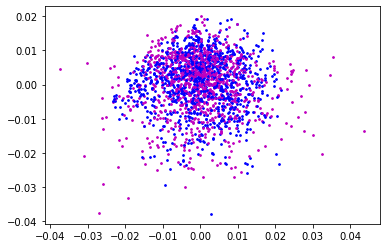

In [16]:
clean_output1 = model1.predict(X_train)
p_output1 = model1.predict(xp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
S_ = ica.fit_transform(clean_output1)
S1_ = ica.fit_transform(p_output1)

clean_output1=pca.fit_transform(clean_output1)
p_output1=pca.fit_transform(p_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=S_[j][0]
    # print(len(y[0]))
    x =S_[j][1]
    y1=S1_[j][0]
    x1 = S1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [17]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(SunModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [18]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv_1 (Pru (None, 52, 44, 20)   1942        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_pool_1 (Pru (None, 26, 22, 20)   1           prune_low_magnitude_conv_1[0][0] 
__________________________________________________________________________________________________
prune_low_magnitude_conv_2 (Pru (None, 24, 20, 40)   14442       prune_low_magnitude_pool_1[0][0] 
____________________________________________________________________________________________

### Pruning Evaluation

POISON DATA

In [19]:
SunBDPoison.append(model_for_pruning.evaluate(xp,yp)[1])
SunBDPoison

401/401 [==============================] - 2s 3ms/step - loss: 4.7541e-04 - accuracy: 1.0000


[0.9999220371246338, 0.9999220371246338]

In [20]:
np.argmax(SunModel.predict(xp),axis=1)

array([0, 0, 0, ..., 0, 0, 0])

CLEAN TEST DATA

In [21]:
SunBDClean.append(model_for_pruning.evaluate(X_test,Y_test)[1])
SunBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.4011 - accuracy: 0.9778


[0.9777864217758179, 0.9777864217758179]

In [22]:
np.argmax(model_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [23]:
model_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 6s 32ms/step - loss: 0.5283 - accuracy: 0.9069 - val_loss: 0.4169 - val_accuracy: 0.9195
Epoch 2/10
82/82 [==============================] - 2s 22ms/step - loss: 0.1415 - accuracy: 0.9766 - val_loss: 0.3771 - val_accuracy: 0.9333
Epoch 3/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0617 - accuracy: 0.9904 - val_loss: 0.3890 - val_accuracy: 0.9394
Epoch 4/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0297 - accuracy: 0.9942 - val_loss: 0.3925 - val_accuracy: 0.9377
Epoch 5/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.4030 - val_accuracy: 0.9446
Epoch 6/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.4306 - val_accuracy: 0.9420
Epoch 7/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.5009 - val_accuracy: 0.9325
Epoch 8/10
82

In [24]:
model_for_pruning.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
prune_low_magnitude_conv_1 (Pru (None, 52, 44, 20)   1942        input[0][0]                      
__________________________________________________________________________________________________
prune_low_magnitude_pool_1 (Pru (None, 26, 22, 20)   1           prune_low_magnitude_conv_1[0][0] 
__________________________________________________________________________________________________
prune_low_magnitude_conv_2 (Pru (None, 24, 20, 40)   14442       prune_low_magnitude_pool_1[0][0] 
____________________________________________________________________________________________

## Fine Pruning Evaluation

Poison Data

In [25]:
np.argmax(model_for_pruning.predict(xp),axis=1)

array([344,  16, 977, ...,   0,   0,   0])

In [26]:
SunBDPoison.append(model_for_pruning.evaluate(xp,yp)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.7896 - accuracy: 0.5055


Clean Test Data

In [27]:
np.argmax(model_for_pruning.predict(X_test),axis=1)

array([950, 992, 977, ..., 770, 304, 719])

In [28]:
SunBDClean.append(model_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.6076 - accuracy: 0.8970


## Reconstruct model by adding layer

N+1 Classes

In [29]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

model2= Model(inputs=model_for_pruning.input, outputs=model_for_pruning.layers[-2].output)
# model2.summary()
model3 = Sequential()
model3.add(model2)
model3.add(Dense(1284, activation='softmax'))
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 160)               789659    
_________________________________________________________________
dense (Dense)                (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [30]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

model3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 27ms/step - loss: 10.2559 - accuracy: 0.0022 - val_loss: 7.0351 - val_accuracy: 0.0052
Epoch 2/10
82/82 [==============================] - 2s 20ms/step - loss: 6.7764 - accuracy: 0.0118 - val_loss: 6.1980 - val_accuracy: 0.0494
Epoch 3/10
82/82 [==============================] - 2s 20ms/step - loss: 5.3008 - accuracy: 0.1188 - val_loss: 4.7400 - val_accuracy: 0.2303
Epoch 4/10
82/82 [==============================] - 2s 20ms/step - loss: 3.2767 - accuracy: 0.3946 - val_loss: 3.5502 - val_accuracy: 0.4468
Epoch 5/10
82/82 [==============================] - 2s 20ms/step - loss: 1.9120 - accuracy: 0.6177 - val_loss: 2.9923 - val_accuracy: 0.5688
Epoch 6/10
82/82 [==============================] - 2s 20ms/step - loss: 1.1584 - accuracy: 0.7571 - val_loss: 2.8622 - val_accuracy: 0.6017
Epoch 7/10
82/82 [==============================] - 2s 20ms/step - loss: 0.7432 - accuracy: 0.8369 - val_loss: 2.7152 - val_accuracy: 0.6667
Epoch 8/10
8

## New Model Evaluation 

Clean Test Data

In [31]:
np.argmax(model3.predict(X_test),axis=1)

array([950, 992,  64, ..., 770, 772, 872])

In [32]:
SunBDClean.append(model3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.8555 - accuracy: 0.7438


Poison data

In [33]:
np.argmax(model3.predict(xp),axis=1)

array([1087,  335,   64, ...,  712,  149,  387])

In [34]:
SunBDPoison.append(model3.evaluate(xp,yp)[1])

401/401 [==============================] - 1s 3ms/step - loss: 28.7867 - accuracy: 7.7942e-05


Conclusion : Low Accuracy---it couldn't  predict successfully

# BadNet2: Anonymous_BD_Net

In [108]:
AnonyModel = keras.models.load_model("/content/drive/MLsecurity_project/models/anonymous_bd_net.h5")
AnonyModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

In [109]:
Anonypoison_data_filename = "/content/drive/MLsecurity_project/data/eyebrows_poisoned_data.h5"
Anonyxp, Anonyyp = data_loader(Anonypoison_data_filename)
Anonyxp = data_preprocess(Anonyxp)

In [110]:
AnonyModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

## BadNet2 Evaluation

In [111]:
AnonyPoison=[]
AnonyPoison.append(AnonyModel.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 1.0021 - accuracy: 0.9139


In [112]:
np.argmax(AnonyModel.predict(Anonyxp),axis=1)

array([5, 5, 5, ..., 5, 5, 5])

In [113]:
AnonyClean=[]
AnonyClean.append(AnonyModel.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


In [114]:
np.argmax(AnonyModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [115]:
from keras.models import Model

AnonyModel1= Model(inputs=AnonyModel.input, outputs=AnonyModel.layers[-6].output)
AnonyModel1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0   

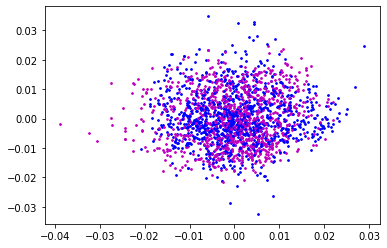

In [116]:
Anonyclean_output1 = AnonyModel1.predict(X_train)
Anonyp_output1 = AnonyModel1.predict(xp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
AnonyS_ = ica.fit_transform(Anonyclean_output1)
AnonyS1_ = ica.fit_transform(Anonyp_output1)

Anonyclean_output1=pca.fit_transform(Anonyclean_output1)
Anonyp_output1=pca.fit_transform(Anonyp_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=AnonyS_[j][0]
    # print(len(y[0]))
    x =AnonyS_[j][1]
    y1=AnonyS1_[j][0]
    x1 = AnonyS1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [117]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

Anonymodel_for_pruning = prune_low_magnitude(AnonyModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
Anonymodel_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Pruning Evaluation

In [118]:
AnonyPoison.append(Anonymodel_for_pruning.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 1.0021 - accuracy: 0.9139


In [119]:
np.argmax(Anonymodel_for_pruning.predict(Anonyxp),axis=1)

array([5, 5, 5, ..., 5, 5, 5])

CLEAN TEST DATA

In [120]:
AnonyClean.append(Anonymodel_for_pruning.evaluate(X_test,Y_test)[1])
AnonyClean

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


[0.9600935578346252, 0.9600935578346252]

In [121]:
np.argmax(Anonymodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [122]:
Anonymodel_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 5s 31ms/step - loss: 0.3113 - accuracy: 0.9338 - val_loss: 0.2220 - val_accuracy: 0.9429
Epoch 2/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0626 - accuracy: 0.9874 - val_loss: 0.2238 - val_accuracy: 0.9446
Epoch 3/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0220 - accuracy: 0.9960 - val_loss: 0.2215 - val_accuracy: 0.9481
Epoch 4/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.2189 - val_accuracy: 0.9541
Epoch 5/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.2108 - val_accuracy: 0.9550
Epoch 6/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.2093 - val_accuracy: 0.9550
Epoch 7/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.2062 - val_accuracy: 0.9532
Epoch 8/10
82

## Fine Pruning Evaluation

Poison Data

In [123]:
AnonyPoison.append(Anonymodel_for_pruning.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 2.7333 - accuracy: 0.7765


In [124]:
np.argmax(Anonymodel_for_pruning.predict(Anonyxp),axis=1)

array([  5, 903,   5, ...,   5,   5,   5])

Clean Test Data

In [125]:
np.argmax(Anonymodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

In [126]:
AnonyClean.append(Anonymodel_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.1985 - accuracy: 0.9646


## Reconstruct model by adding layer

N+1 Classes

In [127]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

Anonymodel2= Model(inputs=Anonymodel_for_pruning.input, outputs=Anonymodel_for_pruning.layers[-2].output)
# model2.summary()
Anonymodel3 = Sequential()
Anonymodel3.add(Anonymodel2)
Anonymodel3.add(Dense(1284, activation='softmax'))
Anonymodel3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
Anonymodel3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_9 (Functional)         (None, 160)               789659    
_________________________________________________________________
dense_4 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [128]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

Anonymodel3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 31ms/step - loss: 9.6163 - accuracy: 0.0029 - val_loss: 6.9266 - val_accuracy: 0.0069
Epoch 2/10
82/82 [==============================] - 2s 21ms/step - loss: 6.4363 - accuracy: 0.0357 - val_loss: 5.2525 - val_accuracy: 0.1593
Epoch 3/10
82/82 [==============================] - 2s 20ms/step - loss: 3.7110 - accuracy: 0.3380 - val_loss: 3.2607 - val_accuracy: 0.4779
Epoch 4/10
82/82 [==============================] - 2s 20ms/step - loss: 1.4451 - accuracy: 0.7199 - val_loss: 2.4846 - val_accuracy: 0.6563
Epoch 5/10
82/82 [==============================] - 2s 21ms/step - loss: 0.6349 - accuracy: 0.8665 - val_loss: 2.2291 - val_accuracy: 0.7134
Epoch 6/10
82/82 [==============================] - 2s 20ms/step - loss: 0.2382 - accuracy: 0.9498 - val_loss: 2.2050 - val_accuracy: 0.7437
Epoch 7/10
82/82 [==============================] - 2s 20ms/step - loss: 0.0937 - accuracy: 0.9790 - val_loss: 2.3114 - val_accuracy: 0.7576
Epoch 8/10
82

## New Model Evaluation 

Clean Test Data

In [129]:
np.argmax(Anonymodel3.predict(X_test),axis=1)

array([ 950,  992, 1008, ...,  770,  304,  825])

In [130]:
AnonyClean.append(Anonymodel3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.3341 - accuracy: 0.7917


Poison data

In [132]:
AnonyPoison.append(Anonymodel3.evaluate(Anonyxp,Anonyyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 129.8944 - accuracy: 9.7428e-05


# BadNet3: multi_trigger_multi_target_bd_net

In [51]:
MultiModel = keras.models.load_model("/content/drive/MLsecurity_project/models/multi_trigger_multi_target_bd_net.h5")

In [52]:
Multipoison_data_filename = "/content/drive/MLsecurity_project/data/eyebrows_poisoned_data.h5"
Multixp, Multiyp = data_loader(Multipoison_data_filename)
Multixp = data_preprocess(Multixp)

In [53]:
MultiModel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])

## BadNet Evaluation

POISON DATA

In [54]:
MultiBDPoison=[]
MultiBDClean=[]
MultiBDPoison.append(MultiModel.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 1.0021 - accuracy: 0.9139


In [55]:
np.argmax(MultiModel.predict(Multixp),axis=1)

array([5, 5, 5, ..., 5, 5, 5])

CLEAN TEST DATA

In [56]:
MultiBDClean.append(MultiModel.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


In [57]:
np.argmax(MultiModel.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

## Activations of the last hidden layer projected onto the TOP principle components.

In [58]:
from keras.models import Model

Multimodel1= Model(inputs=MultiModel.input, outputs=MultiModel.layers[-6].output)
Multimodel1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 55, 47, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 52, 44, 20)        980       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 26, 22, 20)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 20, 40)        7240      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 12, 10, 40)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 10, 8, 60)         21660     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 5, 4, 60)          0   

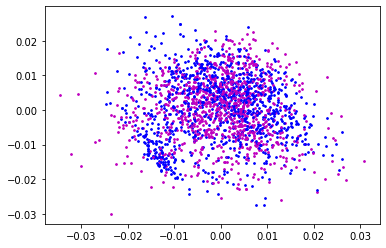

In [59]:
Multiclean_output1 = Multimodel1.predict(X_train)
Multip_output1 = Multimodel1.predict(Multixp)

from sklearn.decomposition import PCA,FastICA
pca=PCA(n_components=3)
ica = FastICA(n_components=3)
MultiS_ = ica.fit_transform(Multiclean_output1)
MultiS1_ = ica.fit_transform(Multip_output1)

Multiclean_output1=pca.fit_transform(Multiclean_output1)
Multip_output1=pca.fit_transform(Multip_output1)

import pandas as pd
import matplotlib.pyplot as plt
for j in range(1000):
    y=MultiS_[j][0]
    # print(len(y[0]))
    x =MultiS_[j][1]
    y1=MultiS1_[j][0]
    x1 = MultiS1_[j][1]
    plt.scatter(x,y,s=3,color = 'm')
    plt.scatter(x1,y1,s=3,color = 'b')
plt.show()

The representations of
poisoned inputs (in BLUE) have a similar distribution as those of
clean inputs, thus both clusters formed by k-means clustering
contain a significant number of poisoned samples.

## Fine Pruning

### Pruning

In [60]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 1
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

Multimodel_for_pruning = prune_low_magnitude(MultiModel, **pruning_params)

# `prune_low_magnitude` requires a recompile.
Multimodel_for_pruning.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])


#model_for_pruning.summary()
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Pruning Evaluation

POISON DATA

In [61]:
MultiBDPoison.append(Multimodel_for_pruning.evaluate(xp,yp)[1])
MultiBDPoison

401/401 [==============================] - 2s 3ms/step - loss: 119.2049 - accuracy: 0.0000e+00


[0.9134840369224548, 0.0]

In [62]:
np.argmax(Multimodel_for_pruning.predict(xp),axis=1)

array([8, 8, 8, ..., 8, 8, 8])

CLEAN TEST DATA

In [63]:
MultiBDClean.append(Multimodel_for_pruning.evaluate(X_test,Y_test)[1])
MultiBDClean

401/401 [==============================] - 1s 3ms/step - loss: 0.2382 - accuracy: 0.9601


[0.9600935578346252, 0.9600935578346252]

In [64]:
np.argmax(Multimodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

### Fine Tune

In [65]:
Multimodel_for_pruning.fit(X_train, Y_train,
                   batch_size=batch_size, epochs=10, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/10
82/82 [==============================] - 5s 34ms/step - loss: 0.3063 - accuracy: 0.9375 - val_loss: 0.2289 - val_accuracy: 0.9455
Epoch 2/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0598 - accuracy: 0.9871 - val_loss: 0.2053 - val_accuracy: 0.9481
Epoch 3/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0206 - accuracy: 0.9958 - val_loss: 0.2145 - val_accuracy: 0.9437
Epoch 4/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.2030 - val_accuracy: 0.9541
Epoch 5/10
82/82 [==============================] - 2s 21ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.1954 - val_accuracy: 0.9576
Epoch 6/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1913 - val_accuracy: 0.9567
Epoch 7/10
82/82 [==============================] - 2s 22ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.1999 - val_accuracy: 0.9584
Epoch 8/10
82

## Fine Pruning Evaluation

Poison Data

In [66]:
np.argmax(Multimodel_for_pruning.predict(Multixp),axis=1)

array([   5,  607, 1004, ...,    5,    5,    5])

In [67]:
MultiBDPoison.append(Multimodel_for_pruning.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 2.9054 - accuracy: 0.7583


Clean Test Data

In [68]:
np.argmax(Multimodel_for_pruning.predict(X_test),axis=1)

array([950, 992, 823, ..., 770, 304, 872])

In [69]:
MultiBDClean.append(Multimodel_for_pruning.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 0.2076 - accuracy: 0.9630


## Reconstruct model by adding layer

N+1 Classes

In [70]:
from keras import Sequential
from keras.layers import  Dense
from keras.models import Model

Multimodel2= Model(inputs=Multimodel_for_pruning.input, outputs=Multimodel_for_pruning.layers[-2].output)
# model2.summary()
Multimodel3 = Sequential()
Multimodel3.add(model2)
Multimodel3.add(Dense(1284, activation='softmax'))
Multimodel3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=Adam(), metrics=['accuracy'])
Multimodel3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 160)               789659    
_________________________________________________________________
dense_2 (Dense)              (None, 1284)              206724    
Total params: 996,383
Trainable params: 601,804
Non-trainable params: 394,579
_________________________________________________________________


Train by clean_validation data

In [71]:
# yp1=yp
# Combined_X=np.append(x,xp[1:100],axis=0)
# yp1[0:yp.size]=1283
# Combined_Y=np.append(y,yp1[1:100])
# Combined_Y.size
# indices=np.arange(Combined_X.shape[0])
# np.random.shuffle(indices)
# Combined_X=Combined_X[indices]
# Combined_Y=Combined_Y[indices]
# model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=Adam(), metrics=['accuracy'])
# X_ptrain, X_ptest, Y_ptrain, Y_ptest = train_test_split(
#         Combined_X, Combined_Y, test_size=0.2, random_state=2)
# model3.fit(
#   X_train,
#   Y_train,
#   epochs=10,
#   validation_split=0.2,
#   batch_size = 20
# )

Multimodel3.fit(X_train, Y_train,
                 batch_size=batch_size, epochs=10, validation_split=validation_split,
                 callbacks=callbacks)


Epoch 1/10
82/82 [==============================] - 5s 29ms/step - loss: 9.0648 - accuracy: 0.0031 - val_loss: 6.9832 - val_accuracy: 0.0130
Epoch 2/10
82/82 [==============================] - 2s 24ms/step - loss: 6.5732 - accuracy: 0.0351 - val_loss: 5.5885 - val_accuracy: 0.1160
Epoch 3/10
82/82 [==============================] - 2s 20ms/step - loss: 4.2482 - accuracy: 0.2593 - val_loss: 3.6996 - val_accuracy: 0.4208
Epoch 4/10
82/82 [==============================] - 2s 20ms/step - loss: 1.8468 - accuracy: 0.6357 - val_loss: 2.8658 - val_accuracy: 0.6017
Epoch 5/10
82/82 [==============================] - 2s 20ms/step - loss: 0.7809 - accuracy: 0.8327 - val_loss: 2.4204 - val_accuracy: 0.6823
Epoch 6/10
82/82 [==============================] - 2s 20ms/step - loss: 0.3255 - accuracy: 0.9269 - val_loss: 2.4700 - val_accuracy: 0.7290
Epoch 7/10
82/82 [==============================] - 2s 20ms/step - loss: 0.1133 - accuracy: 0.9767 - val_loss: 2.6528 - val_accuracy: 0.7532
Epoch 8/10
82

## New Model Evaluation 

Clean Test Data

In [72]:
np.argmax(Multimodel3.predict(X_test),axis=1)

array([950, 992, 623, ..., 770, 506, 872])

In [73]:
MultiBDClean.append(Multimodel3.evaluate(X_test,Y_test)[1])

401/401 [==============================] - 1s 3ms/step - loss: 2.5549 - accuracy: 0.7895


Poison data

In [74]:
np.argmax(Multimodel3.predict(Multixp),axis=1)

array([ 500,  790, 1200, ...,  328,  258,  680])

In [75]:
MultiBDPoison.append(Multimodel3.evaluate(Multixp,Multiyp)[1])

321/321 [==============================] - 1s 3ms/step - loss: 56.9860 - accuracy: 1.9486e-04


Conclusion : Low Accuracy---it couldn't  predict successfully

# Analysis

In [133]:
import pandas as pd
data = [SunBDPoison,SunBDClean,AnonyPoison,AnonyClean,MultiBDPoison,MultiBDClean]
DF = pd.DataFrame(data, columns=[" BadNet ","Pruning"," Fine-Pruning  ","Reconstruct Model"])
DF.index = ['Sunglasses Poison Data','Sunglasses Clean Data','Anonymous Poison Data','Anonymous Clean Data','Multi-Trigger Poison Data','Multi-Trigger Clean Data']
DF

,BadNet,Pruning,Fine-Pruning,Reconstruct Model
Sunglasses Poison Data,0.999922,0.999922,0.505534,0.000078
Sunglasses Clean Data,0.977786,0.977786,0.897038,0.743804
Anonymous Poison Data,0.913484,0.913484,0.776500,0.000097
Anonymous Clean Data,0.960094,0.960094,0.964614,0.791738
Multi-Trigger Poison Data,0.913484,0.000000,0.758281,0.000195
Multi-Trigger Clean Data,0.960094,0.960094,0.962977,0.789478
